# Notebook 2: Tire Degradation Rules Implementation

This notebook focuses on implementing the rule set related to tire degradation for our F1 Strategy Engine. These rules are crucial for race strategy as they determine when a car should pit based on tire performance analysis.

## Overview of Degradation Rules

We'll implement three core rules:

1. **High Degradation Rate Pit Stop**
   - IF (DegradationRate > 0.15 AND TyreAge > 10)
   - THEN recommend priority pit stop
   - CONFIDENCE: 0.85

2. **Stint Extension for Low Degradation**
   - IF (DegradationRate < 0.08 AND TyreAge > 12 AND Position < 5)
   - THEN recommend extending current stint
   - CONFIDENCE: 0.75

3. **Early Degradation Warning**
   - IF (DegradationRate increases by more than 0.03 in 3 consecutive laps)
   - THEN recommend pit stop preparation
   - CONFIDENCE: 0.7

Each rule handles specific aspects of tire degradation strategy that F1 teams consider during races.

---

## 1. Importing necessary Libraries

In [41]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
sys.path.append(os.path.abspath('../'))  
from ML_tyre_pred.ML_utils import N02_model_tire_predictions as tdp

# Import Experta components
from experta import Rule, MATCH, TEST



####################### Import Custom Fact Classes ###################
from utils.N01_agent_setup import (
    TelemetryFact,
    DegradationFact,
    RaceStatusFact,
    StrategyRecommendation,
    F1StrategyEngine,
    
)
from utils.N01_agent_setup import(
    get_current_degradation,
    load_tire_predictions,
    transform_tire_predictions
)
 
# Configuring plots 

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale= 1.2)


---

## 2. Making variable analysis for specifying thresholds

### 2.1 Analyzing Degradation Data

In [42]:
# Load and prepare tire degradation data
def load_degradation_data(file_path='../../outputs/week5/tire_degradation_fuel_adjusted.csv'):
    """
    Load real tire degradation data and prepare it for rule evaluation
    
    Args:
        file_path: Path to the degradation data CSV file
        
    Returns:
        DataFrame with processed tire degradation data
    """
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    
    # Convert float columns to integers where appropriate
    integer_columns = ['Position', 'TyreAge', 'DriverNumber', 'CompoundID', 'TeamID']
    for col in integer_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    # Sort data for consistency
    df = df.sort_values(['DriverNumber', 'Stint', 'TyreAge'])
    
    # Calculate race lap by accumulating TyreAge across stints
    # First, get the maximum TyreAge for each completed stint
    max_age_by_stint = df.groupby(['DriverNumber', 'Stint'])['TyreAge'].max().reset_index()
    max_age_by_stint = max_age_by_stint.rename(columns={'TyreAge': 'StintLength'})
    
    # Create a lookup for previous stint lengths
    stint_lengths = {}
    for driver in df['DriverNumber'].unique():
        driver_stints = max_age_by_stint[max_age_by_stint['DriverNumber'] == driver]
        
        # Calculate cumulative stint lengths
        cumulative_lengths = [0]  # Start with 0 for the first stint
        for i in range(len(driver_stints) - 1):
            cumulative_lengths.append(
                cumulative_lengths[-1] + driver_stints.iloc[i]['StintLength']
            )
        
        # Store in dictionary
        stint_lengths[driver] = {
            stint: length for stint, length in zip(
                driver_stints['Stint'], cumulative_lengths
            )
        }
    
    # Function to calculate race lap
    def calculate_race_lap(row):
        driver = row['DriverNumber']
        stint = row['Stint']
        tyre_age = row['TyreAge']
        
        # Get the starting lap for this stint
        start_lap = stint_lengths.get(driver, {}).get(stint, 0)
        
        # Add current TyreAge to get race lap
        return start_lap + tyre_age
    
    # Apply function to calculate race lap
    df['RaceLap'] = df.apply(calculate_race_lap, axis=1)
    
    # For each driver-stint combination, calculate previous degradation rates
    # This will be useful for Rule 3 (Early Degradation Warning)
    def get_previous_rates(group, n=3):
        """Get previous n degradation rates for each row in the group"""
        rates = []
        for i in range(len(group)):
            if i < n:
                # Not enough previous data
                rates.append(group.iloc[:i+1]['DegradationRate'].tolist())
            else:
                # Get last n rates including current
                rates.append(group.iloc[i-n+1:i+1]['DegradationRate'].tolist())
        return rates
    
    # Apply function to each driver-stint group
    df['PreviousRates'] = df.groupby(['DriverNumber', 'Stint']).apply(
        lambda x: get_previous_rates(x)
    ).explode().tolist()
    
    return df



In [43]:
# Load the data
degradation_data = load_degradation_data()

# Display sample of the data
print("Loaded degradation data:")
display(degradation_data.head())



Successfully loaded data from ../../outputs/week5/tire_degradation_fuel_adjusted.csv
Loaded degradation data:


C:\Users\victo\AppData\Local\Temp\ipykernel_1948\4014458323.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['PreviousRates'] = df.groupby(['DriverNumber', 'Stint']).apply(


,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber,FuelAdjustedLapTime,FuelAdjustedDegPercent,DegradationRate,RaceLap,PreviousRates
0,1.0,256.0,261.0,276.0,275.0,1,1.0,0,9,2,1,0.9848,1,83.935,0.000000,0.000000,1.0,[0.0]
16,1.0,252.0,257.0,276.0,295.0,1,2.0,0,9,2,2,0.9697,1,80.457,-4.143683,-3.941625,2.0,"[0.0, -3.941624999999988]"
20,1.0,249.0,256.0,276.0,297.0,1,3.0,0,9,2,3,0.9545,1,80.609,-3.962590,0.232092,3.0,"[0.0, -3.941624999999988, 0.2320916666666619]"
48,1.0,255.0,256.0,276.0,300.0,1,4.0,0,9,2,4,0.9394,1,80.511,-4.079347,0.073592,4.0,"[-3.941624999999988, 0.2320916666666619, 0.073..."
50,1.0,254.0,256.0,277.0,301.0,1,5.0,0,9,2,5,0.9242,1,80.503,-4.088878,0.007353,5.0,"[0.2320916666666619, 0.0735921568627446, 0.007..."


---

### 2.2 Chossing thresholds for degradation

DegradationRate statistics:


count    1180.000000
mean        0.000665
std         0.591501
min        -3.941625
25%        -0.050319
50%         0.065385
75%         0.167878
max         2.113000
Name: DegradationRate, dtype: float64


Statistics for positive degradation values only:


count    688.000000
mean       0.248009
std        0.296526
min        0.007353
25%        0.111207
50%        0.148136
75%        0.280840
max        2.113000
Name: DegradationRate, dtype: float64

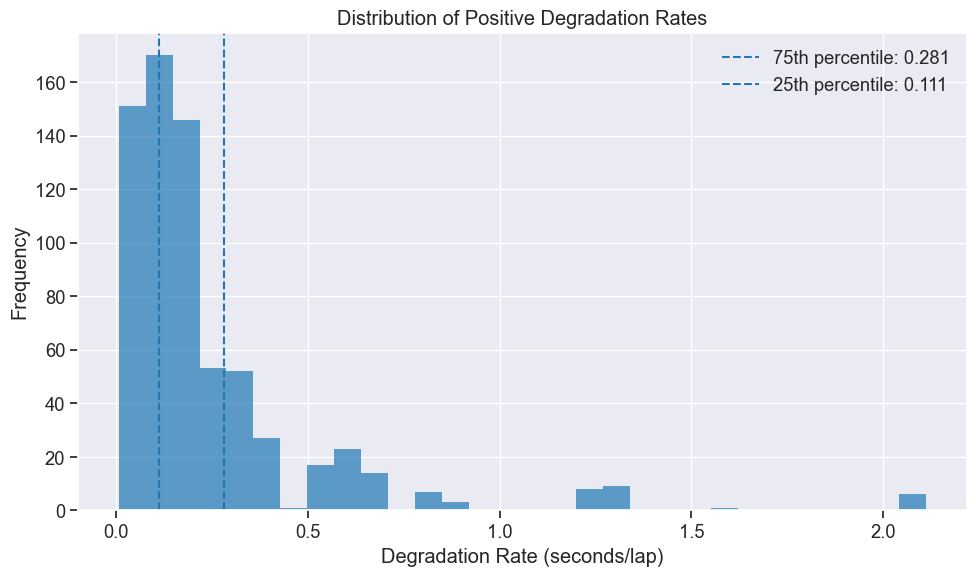


Suggested thresholds based on data distribution:
High Degradation Threshold: 0.281 seconds/lap
Low Degradation Threshold: 0.111 seconds/lap


In [44]:
# Encapsulate the degradation rate analysis into a function
def analyze_degradation_rate(degradation_data):
    """
    Analyze the distribution of positive degradation rates to suggest high/low thresholds,
    and plot the histogram with percentile lines.
    
    Returns:
        tuple(float, float): (high_degradation_threshold, low_degradation_threshold)
    """
    import matplotlib.pyplot as plt
    from IPython.display import display

    # Overall statistics
    print("DegradationRate statistics:")
    display(degradation_data['DegradationRate'].describe())

    # Filter to positive values only
    positive_deg = degradation_data[degradation_data['DegradationRate'] > 0]['DegradationRate']
    print("\nStatistics for positive degradation values only:")
    display(positive_deg.describe())

    # Plot distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(positive_deg, bins=30, alpha=0.7)
    q75 = positive_deg.quantile(0.75)
    q25 = positive_deg.quantile(0.25)
    ax.axvline(q75, linestyle='--', label=f'75th percentile: {q75:.3f}')
    ax.axvline(q25, linestyle='--', label=f'25th percentile: {q25:.3f}')
    ax.set_xlabel('Degradation Rate (seconds/lap)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Positive Degradation Rates')
    ax.legend()
    fig.tight_layout()
    plt.show()

    # Compute suggested thresholds
    high_degradation_threshold = q75
    low_degradation_threshold = q25

    print("\nSuggested thresholds based on data distribution:")
    print(f"High Degradation Threshold: {high_degradation_threshold:.3f} seconds/lap")
    print(f"Low Degradation Threshold: {low_degradation_threshold:.3f} seconds/lap")

    return high_degradation_threshold, low_degradation_threshold

high_deg_thresh, low_deg_thresh = analyze_degradation_rate(degradation_data)


---

### 2.3 Plotting degradation for sample drivers for putting thresholds

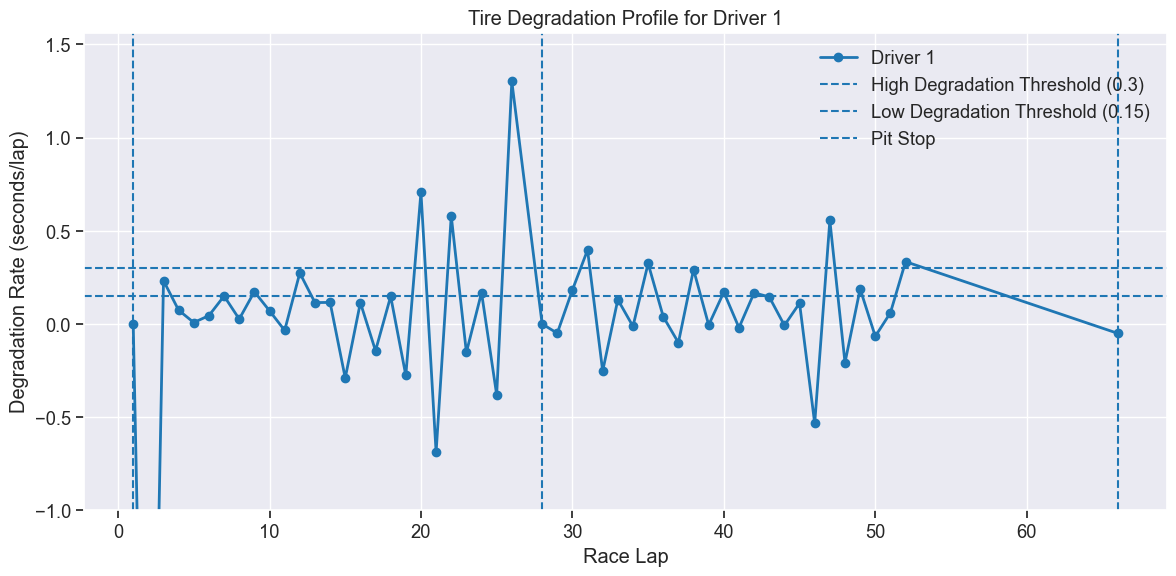

In [45]:
# Encapsulate the driver degradation profile plot into a function
def plot_driver_degradation_profile(degradation_data, driver_number=None,
                                    high_threshold=0.3, low_threshold=0.15):
    """
    Plot degradation rate across race laps for a given driver, with thresholds and pit stops.

    Args:
        degradation_data (pd.DataFrame): must contain 'DriverNumber', 'RaceLap', 'DegradationRate', 'Stint'
        driver_number (int, optional): specific driver to plot; if None, uses the first in the dataset
        high_threshold (float): y-value for high degradation threshold line
        low_threshold (float): y-value for low degradation threshold line

    Returns:
        matplotlib.figure.Figure: the created figure
    """
    import matplotlib.pyplot as plt

    # Choose driver
    if driver_number is None:
        driver_number = degradation_data['DriverNumber'].unique()[0]
    driver_df = degradation_data[degradation_data['DriverNumber'] == driver_number]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(driver_df['RaceLap'], driver_df['DegradationRate'], 'o-', linewidth=2,
            label=f'Driver {driver_number}')

    # Add threshold lines
    ax.axhline(y=high_threshold, linestyle='--', label=f'High Degradation Threshold ({high_threshold})')
    ax.axhline(y=low_threshold, linestyle='--', label=f'Low Degradation Threshold ({low_threshold})')

    # Mark pit stops (stint changes)
    stint_changes = driver_df['RaceLap'][driver_df['Stint'].diff() != 0].tolist()
    for lap in stint_changes:
        # Only label the first pit stop line
        label = 'Pit Stop' if lap == stint_changes[0] else ""
        ax.axvline(x=lap, linestyle='--', label=label)

    # Limit y-axis bottom
    ax.set_ylim(bottom=-1)

    ax.set_xlabel('Race Lap')
    ax.set_ylabel('Degradation Rate (seconds/lap)')
    ax.set_title(f'Tire Degradation Profile for Driver {driver_number}')
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    plt.show()

    return fig

driver_fig = plot_driver_degradation_profile(degradation_data)


---

## 3. Defining the Engine Class with all three degradation rules

---

In [46]:
class F1DegradationRules(F1StrategyEngine):
    """
    Engine implementing tire degradation related rules for F1 strategy.
    Inherits the base functionality from F1StrategyEngine.
    """

    @Rule(
        # Capture degradation_rate for evaluation and use in action
        DegradationFact(degradation_rate=MATCH.deg_rate),
        # Test if degradation rate is above threshold
        TEST(lambda deg_rate: float(deg_rate) > 0.3),  
        # Capture tire_age for evaluation and use in action
        TelemetryFact(tire_age=MATCH.age),
        # Test if tire age is sufficient
        TEST(lambda age: int(age) > 10),
        # Capture current lap for recommendation
        RaceStatusFact(lap=MATCH.lap)
    )
    def high_degradation_pit_stop(self, deg_rate, age, lap):
        """
        Rule 1: High Degradation Rate Pit Stop
        IF (DegradationRate > 0.3 AND TyreAge > 10)
        THEN recommend priority pit stop with high confidence
        """
        # Debug output
        print(f"Rule activated: high_degradation_pit_stop")
        print(f"  - Degradation rate: {deg_rate:.3f} (threshold: 0.3)")
        print(f"  - Tire age: {age} (threshold: 10)")
        
        self.declare(
            StrategyRecommendation(
                action="pit_stop",
                confidence=0.8,
                explanation=f"High tire degradation rate detected ({deg_rate:.2f} > 0.3) with significant tire age ({age} laps)",
                priority=2,  # Higher priority due to performance implications
                lap_issued=lap
            )
        )

        # Record that the rule was activated
        self.record_rule_fired("high_degradation_pit_stop")


    @Rule(
    # Capture degradation_rate for evaluation
    DegradationFact(degradation_rate=MATCH.deg_rate),
    # Test if degradation rate is low
    TEST(lambda deg_rate: float(deg_rate) < 0.15),
    # Capture predicted_rates to verify they're also low
    DegradationFact(predicted_rates=MATCH.pred_rates),
    # Verify first predicted rate is also low to avoid contradictions
    TEST(lambda pred_rates: pred_rates is None or 
                           len(pred_rates) == 0 or 
                           float(pred_rates[0]) < 0.20),
    # Capture tire_age for evaluation
    TelemetryFact(tire_age=MATCH.age),
    # Test if tire age is sufficient
    TEST(lambda age: int(age) > 12),
    # Capture current lap for recommendation
    RaceStatusFact(lap=MATCH.lap)
    )
    def stint_extension_recommendation(self, deg_rate, pred_rates, age, lap):
        """
        Rule 2: Stint Extension for Low Degradation (Modificada sin condición de posición)
        IF (DegradationRate < 0.15 AND PredictedRate < 0.20 AND TyreAge > 12)
        THEN recommend extending current stint
        
        Versión actualizada que no considera la posición del piloto
        """
        # Debug output
        print(f"Rule activated: stint_extension_recommendation")
        print(f"  - Degradation rate: {deg_rate:.3f} (threshold: < 0.15)")
        print(f"  - First predicted rate: {pred_rates[0] if pred_rates and len(pred_rates) > 0 else 'N/A'} (threshold: < 0.20)")
        print(f"  - Tire age: {age} (threshold: > 12)")
        
        self.declare(
            StrategyRecommendation(
                action="extend_stint",
                confidence=0.75,
                explanation=f"Low tire degradation ({deg_rate:.2f}) despite tire age ({age} laps). Recommend extending the current stint to maximize advantage.",
                priority=1, # Medium priority as it's an opportunity, not critical
                lap_issued=lap
            )
        )

        self.record_rule_fired("stint_extension_recommendation")

    @Rule(
        # Capture previous_rates for evaluation and use in action
        DegradationFact(previous_rates=MATCH.rates),
        # Test if rates are increasing rapidly
        TEST(lambda rates: rates is not None and 
                          len(rates) >= 3 and 
                          (rates[-1] - rates[-3]) > 0.03),
        # Capture current lap for recommendation
        RaceStatusFact(lap=MATCH.lap)
    )
    def early_degradation_warning(self, rates, lap):
        """
        Rule 3: Early Degradation Warning
        IF (DegradationRate increases by more than 0.03 in 3 consecutive laps)
        THEN recommend pit stop preparation
        """
        # Debug output
        print(f"Rule activated: early_degradation_warning")
        print(f"  - Previous rates: {rates}")
        print(f"  - Increase over 3 laps: {rates[-1] - rates[-3]:.3f} (threshold: > 0.03)")
        
        self.declare(
            StrategyRecommendation(
                action="prepare_pit",
                confidence=0.7, 
                explanation=f"Degradation rate increasing rapidly over the last 3 laps (trend: {rates[-3]:.3f} → {rates[-1]:.3f}). Prepare for potential pit stop.",
                priority=1, # Medium priority as it is a preparation, not immediate action.
                lap_issued=lap
            )
        )

        self.record_rule_fired("early_degradation_warning")


    @Rule(
        # Capture predicted_rates for evaluation and use in action
        DegradationFact(predicted_rates=MATCH.pred_rates),  # Note: corrected from predicted_rate to predicted_rates
        # Test if first predicted rate is high
        TEST(lambda pred_rates: pred_rates is not None and 
                              len(pred_rates) > 0 and 
                              float(pred_rates[0]) > 0.2),
        # Capture tire_age for evaluation
        TelemetryFact(tire_age=MATCH.age),
        # Test if tire age is sufficient
        TEST(lambda age: int(age) > 8),
        # Capture current lap for recommendation
        RaceStatusFact(lap=MATCH.lap)
    )
    def predicted_high_degradation_alert(self, pred_rates, age, lap):
        """
        Rule 4: Predicted High Degradation Alert
        IF (Predicted future degradation rate > 0.2 AND TyreAge > 8)
        THEN recommend considering pit stop based on model prediction
        """
        # Debug output
        print(f"Rule activated: predicted_high_degradation_alert")
        print(f"  - First predicted rate: {pred_rates[0]:.3f} (threshold: > 0.2)")
        print(f"  - Tire age: {age} (threshold: > 8)")
        
        self.declare(
            StrategyRecommendation(
                action="consider_pit",
                confidence=0.8,
                explanation=f"Model predicts critical degradation in upcoming laps (predicted rate: {pred_rates[0]:.3f}s/lap). Consider pit stop strategy.",
                priority=2, # Higher priority due to prediction-based insights
                lap_issued=lap
            )
        )
        
        self.record_rule_fired("predicted_high_degradation_alert")

---

## 4. Testing the Rules 

### 4.1 Testing with real data 

In [47]:
def test_with_real_data(race_data_path, models_path):
    """
    Test the rule engine with real data from the prediction models
    
    Args:
        race_data_path (str): Path to the race telemetry data
        models_path (str): Path to the prediction models
    """
    # Load race data
    import pandas as pd
    race_data = pd.read_csv(race_data_path)
    print(f"Loaded race data with {len(race_data)} rows")
    
    # Print columns to help debugging
    print("Available columns in race_data:")
    print(race_data.columns.tolist())
    
    # Load tire predictions
    predictions = load_tire_predictions(race_data, models_path)
    if predictions is None or len(predictions) == 0:
        print("Failed to generate tire predictions")
        return None
        
    print(f"Generated tire predictions with {len(predictions)} rows")
    
    # Print prediction columns for debugging
    print("Available columns in predictions:")
    print(predictions.columns.tolist())
    
    # Select a driver to test with
    if 'DriverNumber' not in predictions.columns:
        print("Error: 'DriverNumber' column not found in predictions")
        if 'Driver' in predictions.columns:
            predictions['DriverNumber'] = predictions['Driver']
        else:
            print("No suitable driver column found. Cannot proceed.")
            return None
    
    test_driver = predictions['DriverNumber'].unique()[0]
    print(f"Testing with driver {test_driver}")
    
    # Transform predictions to facts
    facts = transform_tire_predictions(predictions, test_driver)
    if not facts:
        print("Failed to transform predictions to facts")
        return None
    
    print("\nGenerated facts:")
    print(f"Degradation fact: {facts['degradation']}")
    print(f"Telemetry fact: {facts['telemetry']}")
    
    # Initialize engine with the facts
    engine = F1DegradationRules()
    engine.reset()
    
    # Determine current lap - use a safer approach
    current_lap = 10  # Default value
    
    # Try different possible column names for lap
    lap_columns = ['LapNumber', 'Lap', 'CurrentLap', 'RaceLap']
    for col in lap_columns:
        if col in race_data.columns:
            try:
                filtered_data = race_data[race_data['DriverNumber'] == test_driver]
                if not filtered_data.empty:
                    current_lap = int(filtered_data[col].max())
                    print(f"Found current lap: {current_lap} using column '{col}'")
                    break
            except:
                pass
    
    # If we couldn't determine the lap, try using the TyreAge from predictions
    if current_lap == 10 and 'CurrentTyreAge' in predictions.columns:
        try:
            current_lap = int(predictions[predictions['DriverNumber'] == test_driver]['CurrentTyreAge'].max())
            print(f"Using CurrentTyreAge as current lap: {current_lap}")
        except:
            pass
            
    total_laps = 60  # Typical F1 race length, adjust as needed
    

    from utils.N01_agent_setup import calculate_race_phase

    engine.declare(RaceStatusFact(
        lap=current_lap,
        total_laps=total_laps,
        race_phase=calculate_race_phase(current_lap, total_laps),
        track_status="clear"
    ))
    
    # Declare the facts
    engine.declare(facts['degradation'])
    engine.declare(facts['telemetry'])
    
    # Run the engine
    print("\nRunning the rule engine...")
    engine.run()
    
    # Check recommendations
    recommendations = engine.get_recommendations()
    print(f"\nGenerated {len(recommendations)} recommendations:")
    
    for i, rec in enumerate(recommendations):
        print(f"\nRecommendation {i+1}:")
        print(f"Action: {rec['action']}")
        print(f"Confidence: {rec['confidence']}")
        print(f"Explanation: {rec['explanation']}")
        print(f"Priority: {rec['priority']}")
        print(f"Lap issued: {rec['lap_issued']}")
    
    # Return the facts and recommendations for further analysis
    return {
        'facts': facts,
        'recommendations': recommendations,
        'engine': engine
    }

In [48]:
# race_data_path = '../../outputs/week3/lap_prediction_data.csv'  
# models_path = '../../outputs/week5/models'  
# test_results = test_with_real_data(race_data_path, models_path)

### 4.2 Testing with multiple drivers

In [49]:
# Function to test multiple drivers
def test_multiple_drivers(race_data_path, models_path, driver_numbers=None):
    """
    Test the rule engine with data from multiple drivers
    
    Args:
        race_data_path: Path to the race data
        models_path: Path to the models
        driver_numbers: List of driver numbers to test (None to test all)
    """
    import pandas as pd

    # Load data and generate predictions (we do this only once)
    print("Loading data and generating predictions...")
    race_data = pd.read_csv(race_data_path)

    # Import necessary functions
    
    predictions = load_tire_predictions(race_data, models_path)

    if predictions is None:
        print("Error generating predictions")
        return

    # Get the available drivers
    available_drivers = predictions['DriverNumber'].unique()
    print(f"Available drivers: {available_drivers}")

    # If no specific drivers are provided, use all available ones
    if driver_numbers is None:
        driver_numbers = available_drivers

    # For each driver, execute the test
    results = {}
    for driver in driver_numbers:
        if driver not in available_drivers:
            print(f"Driver {driver} not found in the data. Skipping...")
            continue

        print(f"\n{'='*50}")
        print(f"TESTING DRIVER {driver}")
        print(f"{'='*50}")

        # Modify the function to work directly with predictions instead of regenerating them
        
        # Filter data for the specific driver
        driver_data = predictions[predictions['DriverNumber'] == driver]

        if driver_data.empty:
            print(f"No data available for driver {driver}")
            continue

        # Transform predictions into facts
        from utils.N01_agent_setup import transform_tire_predictions
        facts = transform_tire_predictions(predictions, driver)

        if not facts:
            print(f"Could not transform predictions for driver {driver}")
            continue

        # Correct degradation_rate if necessary
        if facts and 'degradation' in facts:
            predicted_rates = facts['degradation'].get('predicted_rates', [])
            if predicted_rates and len(predicted_rates) > 0:
                if facts['degradation']['degradation_rate'] == 0.0:
                    facts['degradation']['degradation_rate'] = predicted_rates[0]
                    print(f"CORRECTED: Set degradation_rate to {predicted_rates[0]} from predicted_rates")

        # Initialize engine
        from utils.N01_agent_setup import F1StrategyEngine, RaceStatusFact
        engine = F1DegradationRules()
        engine.reset()

        # Determine current lap
        current_lap = facts['telemetry']['tire_age']
        total_laps = 60  # Typical F1 race

        # Declare race status
        engine.declare(RaceStatusFact(
            lap=current_lap,
            total_laps=total_laps,
            race_phase="mid" if 0.25 <= current_lap / total_laps <= 0.75 else "start" if current_lap / total_laps < 0.25 else "end",
            track_status="clear"
        ))

        # Declare facts
        engine.declare(facts['degradation'])
        engine.declare(facts['telemetry'])

        # Run engine
        print("Running rule engine...")
        engine.run()

        # Get recommendations
        recommendations = engine.get_recommendations()
        print(f"\nGenerated {len(recommendations)} recommendations:")

        for i, rec in enumerate(recommendations):
            print(f"\nRecommendation {i+1}:")
            print(f"Action: {rec['action']}")
            print(f"Confidence: {rec['confidence']}")
            print(f"Explanation: {rec['explanation']}")
            print(f"Priority: {rec['priority']}")
            print(f"Lap issued: {rec['lap_issued']}")

        # Check which rules were triggered
        print("\nTriggered rules:")
        for rule in engine.rules_fired:
            print(f"- {rule['rule']} (Lap {rule['lap']})")

        # Store results
        results[driver] = {
            'facts': facts,
            'recommendations': recommendations,
            'rules_fired': engine.rules_fired
        }

    return results


In [50]:
# Example usage
race_data_path = '../../outputs/week3/lap_prediction_data.csv'  
models_path = '../../outputs/week5/models'  

# Test with specific drivers (you can choose any driver numbers you want to test)
results = test_multiple_drivers(race_data_path, models_path, driver_numbers=[1, 44, 16])

# Alternatively, to test all available drivers:
# results = test_multiple_drivers(race_data_path, models_path)


Loading data and generating predictions...
Data loaded and validated: 1180 rows, 15 columns
Processing Medium tires (ID: 2)...
Processing Hard tires (ID: 3)...
  No laps with new tires for Hard, using TyreAge=2.0 as baseline
Processing Soft tires (ID: 1)...
  No laps with new tires for Soft, using TyreAge=2.0 as baseline
Degradation metrics successfully calculated
Processed data format: 16 features
Created 339 sequences of 5 laps each
Sequences by compound: {1: 158, 2: 147, 3: 34}
Using device: cuda
Global model loaded from: ../../outputs/week5/models\tire_degradation_tcn.pth
Specialized model for compound 1 loaded
Specialized model for compound 2 loaded
Specialized model for compound 3 loaded
Models loaded: 1 global model and 3 specialized models
Prepared tensor for model: shape=torch.Size([339, 5, 16])


c:\Users\victo\Desktop\Documents\Tercer año\Segundo Cuatrimestre\Finales\scripts\ML_tyre_pred\ML_utils\N02_model_tire_predictions.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.    -3.478  0.152 -0.098 -0.008  0.174  0.129 -0.527  0.443  0.107
  0.241 -0.023 -0.209  0.255 -0.041 -0.041  0.213 -0.031 -0.135 -0.025
  0.154 -0.163  0.284 -0.097  0.082  3.925]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[group_idx, 'DegradationRate'] = diffs
c:\Users\victo\Desktop\Documents\Tercer año\Segundo Cuatrimestre\Finales\scripts\ML_tyre_pred\ML_utils\N02_model_tire_predictions.py:550: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github

Generated ensemble predictions for 339 sequences
Formatted results: 1017 predictions for 20 drivers
Available drivers: [ 1  2  4 10 11 14 16 18 20 21 22 23 24 27 31 44 55 63 77 81]

TESTING DRIVER 1
Driver 1, Lap None: degradation = 0.745
Running rule engine...
Rule activated: predicted_high_degradation_alert
  - First predicted rate: 0.745 (threshold: > 0.2)
  - Tire age: 26 (threshold: > 8)
Rule activated: high_degradation_pit_stop
  - Degradation rate: 0.745 (threshold: 0.3)
  - Tire age: 26 (threshold: 10)

Generated 2 recommendations:

Recommendation 1:
Action: consider_pit
Confidence: 0.8
Explanation: Model predicts critical degradation in upcoming laps (predicted rate: 0.745s/lap). Consider pit stop strategy.
Priority: 2
Lap issued: 26

Recommendation 2:
Action: pit_stop
Confidence: 0.8
Explanation: High tire degradation rate detected (0.75 > 0.3) with significant tire age (26 laps)
Priority: 2
Lap issued: 26

Triggered rules:
- predicted_high_degradation_alert (Lap 26)
- high_d

---

---

# Summary of Notebook N02 Accomplishments

I successfully implemented a rule-based expert system focused on tire degradation strategies for Formula 1 racing.

Using the Experta framework, we created a comprehensive set of rules that analyze tire performance data and generate strategic recommendations for pit stops and stint management.


## Key Components Implemented 

1. **Data Analysis and Threshold setting**:
    - Real tire degradation data distributions was analyzed to determine appropiate thresholds.

    - Identified critical degradation values (0.3s/lap hor high degradation, 0.15s/lap for low degradation).

    - Visualized degradation patterns across race laps to validate thresholds.

2. **Rule Engine Architecture**:
    - Extended the base F1StrategyEngine class with specialized tire degradation rules.

    - Implemented adanced pattern matching using MATCH and TEST operators.

    - Created a flexible recommendation system with confidence levels and priorities.

3. **Four Core Degradation Rules**:

    - *High degradation detection* for identifying when tire degradation can reach critical levels.

    - *Stint extension opportunities* recognized when tire ages performing well despite age.

    - *Early Warning System* detects rapidly increasing degradation trends.

    - *Predict Degradation Alerts* : uses model predictions to anticipate future performance. 

4. **Testing Infrastructure**:

    - Developed functions to test with real race data via `test_with_real_data()`.

    - Created multi-driver testing capability `test_multiple_drivers`.


---

## Errors handled 

### Fact Transformation Issues

The `degradation_rate` was being set to 0.0 instead of using the predicted value, so `transform_tire_predictions()` was changed to use the first value from `predicted_rates` as `degradation_rate`. 

### Rule Pattern Refinement 

Some rules were not acivating due to pattern matching issues, so the rules were refactored to use explicit MATCH and TEST operators, capturing variables for evaluation and explanation generation.

## Results Obtained
The implemented system successfully:

### Generates Appropriate Recommendations

Produces "pit_stop" recommendations for high degradation scenarios
Suggests "extend_stint" when tires are performing well
Provides early warnings with "prepare_pit" when degradation trends indicate future issues
Anticipates performance drops with "consider_pit" based on predictive models


### Prioritizes Strategic Decisions

Assigns higher priority to immediate performance concerns
Balances opportunity-based and risk-based recommendations


### Provides Detailed Explanations

Each recommendation includes specific threshold values
Explanations reference current data points for transparency
Debug output tracks exactly which conditions triggered each rule


### Processes Multiple Drivers

System can evaluate entire grid or specific drivers
Enables comparative strategy analysis across different race situations